In [30]:
import pandas as pd
from pandapower.timeseries.run_time_series import run_timeseries
import matplotlib
matplotlib.rcParams['timezone'] = 'Europe/Berlin'

import data_process_base
import importlib
importlib.reload(data_process_base)

try:
    import seaborn
    colors = seaborn.color_palette()
except:
    colors = ["b", "g", "r", "c", "y"]

In [31]:
# create random time series from import data
da = data_process_base.DataAction()
nc = data_process_base.net_calc()

da.folder_path = r"G:\\My Drive\\docs\\Education\\University\\ALUF\\SSE\\6 sem\\Bachelor Thesis\\data\\"
keep_cols = ['DE_KN_residential1_grid_import',
             'DE_KN_residential2_grid_import',
             'utc_timestamp']
da.imp_procc("house_data.csv", keep_cols)

Number of data frame segments =  90
dfList created successfully.


In [32]:
def end_results(sgen_val, iter):
    """Final boss"""
    
    # create df to store output
    col_names = ['line_1', 'line_2', 'line_3', 'line_4', 'line_5', 'line_6', 'line_7', 'line_8']
    end_vals = pd.DataFrame(columns=col_names)
    end_times = pd.DataFrame(dtype='str', columns=col_names)

    for i in range(0, iter):
        # iterative scramble
        night_merge = da.power_merge()

        # assign generator value at random times
        # night_mw = da.sgen_comm(ts=night_merge, wind_length=60, sgen_val=sgen_val, parties=4)
        night_mw = da.sgen_rand(ts=night_merge, sgen_val=sgen_val)

        nc.four_loads_branched_make(night_mw)
        nc.four_loads_branched_out("res_line", "loading_percent")
        nc.four_loads_branched_run()
        nc.four_loads_branched_read_loadpct()

        nc.end_vals_step(nc.ll, end_vals)
        nc.end_times_step(nc.ll, end_times)

    return end_vals, end_times


iter = 10
sgen_val = 0.01 # typical val: 0.010 MW = 10kW
end_vals, end_times = end_results(sgen_val, iter)

100%|██████████| 601/601 [00:02<00:00, 295.13it/s]


In [33]:
end_vals

,line_1,line_2,line_3,line_4,line_5,line_6,line_7,line_8
0,30.201295,21.135412,14.251036,8.495630,10.128902,8.485804,8.492199,8.495908
1,37.188578,26.396773,16.283407,8.497689,20.772226,14.152679,10.905550,8.497967
2,55.750935,52.514383,48.899474,15.846215,8.745577,8.498022,47.703323,15.846364
3,35.848821,29.924542,22.971778,8.808928,11.728385,19.316957,16.134421,8.809196
4,27.665282,20.774642,14.247795,8.498082,8.762430,8.496888,8.484749,8.498360
5,42.133226,22.867168,15.272069,8.501124,28.923193,8.773209,9.579942,8.501401
6,27.655296,20.375010,14.248265,7.384173,8.760974,8.500020,9.578603,7.384493
7,26.925514,20.313505,14.154271,8.503155,11.654500,8.498386,8.168899,8.503433
8,36.030291,30.115988,25.305187,17.561573,13.307241,15.764726,15.777253,17.561707
9,39.766347,30.162355,15.606581,8.565357,17.419698,19.322334,11.592462,8.565632


In [40]:
def line_overloads(end_vals, threshold):
    # count the number of overloads on each line
    return end_vals[end_vals > threshold].count()


threshold = 40
overloads = line_overloads(end_vals, threshold)
print("For", iter, "cases, the line overload occurance was: ")
overloads/iter

For 10 cases, the line overload occurance was: 


line_1    0.2
line_2    0.1
line_3    0.1
line_4    0.0
line_5    0.0
line_6    0.0
line_7    0.1
line_8    0.0
dtype: float64

In [35]:
end_times

,line_1,line_2,line_3,line_4,line_5,line_6,line_7,line_8
0,20:06:00,20:06:00,20:07:00,23:54:00,19:00:00,23:19:00,02:15:00,23:54:00
1,20:13:00,04:46:00,20:46:00,00:01:00,20:14:00,04:45:00,20:04:00,00:01:00
2,03:33:00,03:33:00,03:33:00,19:04:00,00:16:00,00:13:00,03:33:00,19:04:00
3,19:55:00,19:55:00,18:55:00,18:34:00,19:27:00,19:55:00,18:55:00,18:34:00
4,21:13:00,19:51:00,21:22:00,02:34:00,21:01:00,22:55:00,22:08:00,02:34:00
5,19:57:00,19:34:00,03:54:00,00:33:00,20:00:00,19:34:00,21:06:00,00:33:00
6,19:57:00,19:17:00,19:17:00,18:39:00,19:42:00,21:44:00,18:33:00,18:39:00
7,04:00:00,04:00:00,04:00:00,19:15:00,19:40:00,02:43:00,04:00:00,19:15:00
8,18:03:00,18:03:00,18:03:00,18:03:00,20:51:00,23:29:00,20:21:00,18:03:00
9,18:10:00,18:18:00,21:39:00,18:10:00,18:10:00,18:18:00,21:39:00,18:10:00


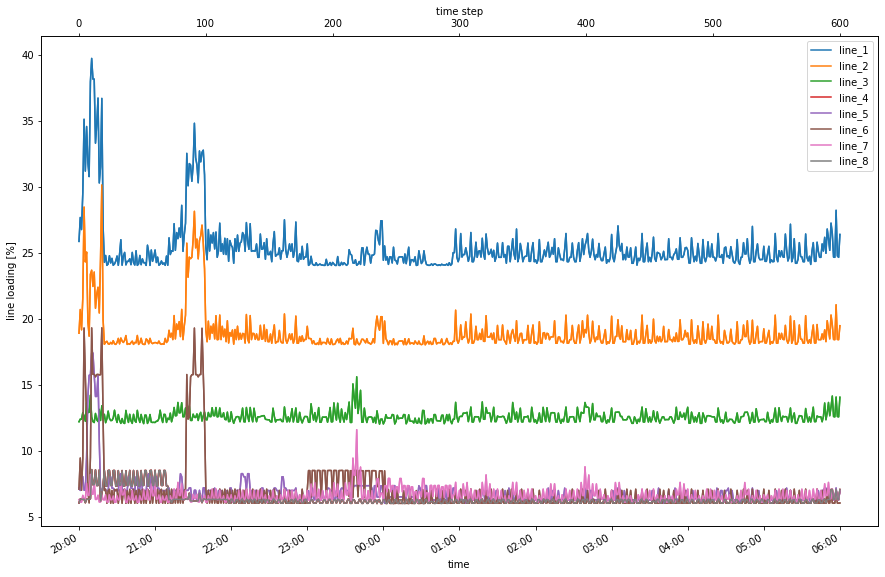

In [36]:
nc.four_loads_branched_plot_linepct()

100%|██████████| 2/2 [00:00<00:00, 39.18it/s]


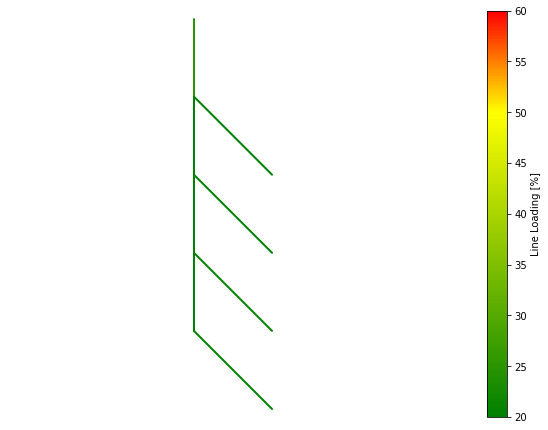

In [37]:
nc.load_graph(nc.net, time_step=170)

In [77]:
from datetime import date
import math

f_date = date(2015, 5, 21)
l_date = date(2016, 11, 27)
delta = l_date - f_date
print("Total days in dfList:", delta.days)

foo = da.parse_procc(da.dfList[0])
bar = len(da.unique_date(foo))-3
foobar = bar*89
print("Unique parsable days for simulation:", foobar)

k = 4
n = foobar
ways = math.pow(n, k) # draw k samples from a set of n elements: n^k
print("Ordered sampling with replacement combinations:", ways)

Total days in dfList: 556
Unique parsable days for simulation: 445
Ordered sampling with replacement combinations: 39213900625.0
